# Part 5: The Generalized Bias-Variance Tradeoff & Double Descent
**A Non-Linear Programming Capstone Project**

## 1. Notebook Objective & Theoretical Framework
This final notebook synthesizes the analytical methods (Part 2), regularization theory (Part 3), and optimization behavior (Part 4) to demonstrate the **Double Descent** phenomenon.

We will move beyond the "single dataset" view and adopt the statistical learning perspective (ISL Ch. 2 and Ch. 10.8). By simulating thousands of parallel universes (datasets), we will empirically decompose the Mean Squared Error into **Bias² + Variance + Irreducible Error**.

**Core Hypothesis (based on *Schaeffer et al.* & *ISL*):**
The "descent" in the over-parameterized regime ($p > n$) occurs because, among the infinite solutions that satisfy $X\beta = y$, the "natural" solver (the Moore-Penrose Pseudoinverse or Gradient Descent initialized at zero) selects the solution with the **minimum $\ell_2$ norm**. This acts as an *implicit* regularization, suppressing the variance that explodes at the interpolation threshold.

### Block 1: The Experimental Design (The Ensemble Generator)
**Goal:** Define the infrastructure to calculate "True" Bias and Variance.

* **Concept:** To measure bias and variance, we cannot use a single training set. We must approximate the expectation over the data distribution $\mathbb{E}_{\mathcal{D}}$.
* **Implementation Details:**
    * Define a `true_function(x)`: $f(x) = \sin(2\pi x)$ or the previous $0.5x^2$.
    * Create a factory function that generates $K$ distinct datasets (e.g., $K=100$), each with $N$ sample points (e.g., $N=15$).
    * **PyTorch/Einsum:** Use broadcasting to generate all $K$ datasets in a single tensor operation for efficiency.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Configuration
K_datasets = 1000   # Number of parallel universes (datasets)
N_samples = 15      # Number of training points per dataset (Interpolation threshold at d=14)
sigma_noise = 0.2   # Irreducible error (noise level)
test_size = 1000    # Size of the test set for integral approximation

# 1. Define the True Function
def true_function(x):
    # Using sin(2*pi*x) as it's a classic choice for showing wiggles, 
    # but we can also use 0.5*x**2 if preferred for continuity with Part 1.
    # Let's use a slightly more complex function to justify high degrees.
    return torch.sin(2 * torch.pi * x)

# 2. The Ensemble Generator (Factory)
def generate_ensemble(K, N, sigma):
    """
    Generates K datasets, each with N points.
    Returns:
        X: (K, N) tensor of inputs
        y: (K, N) tensor of targets
    """
    # Random x in [-1, 1]
    X = torch.rand(K, N) * 2 - 1
    
    # y = f(x) + epsilon
    noise = torch.randn(K, N) * sigma
    y = true_function(X) + noise
    return X, y

# Generate the Test Set (Fixed for all models)
X_test = torch.linspace(-1, 1, test_size).view(-1, 1) # (T, 1)
y_test_true = true_function(X_test)                   # (T, 1)

print(f"Generated {K_datasets} datasets with {N_samples} samples each.")

Generated 1000 datasets with 15 samples each.


### Block 2: The Solver & The Minimum Norm Solution
**Goal:** Define the fitting mechanism that operates across both regimes.

* **Concept:** We need a solver that works for $p < n$ (Classical) and $p > n$ (Over-parameterized).
* **Mathematical Rigor:**
    * For $p \le n$ (Under-parameterized): The solution is unique (if $X$ is full rank). $\hat{\beta} = (X^T X)^{-1} X^T y$.
    * For $p > n$ (Over-parameterized): The system is underdetermined. There are infinite solutions. We explicitly choose the **Minimum Norm Solution**: $\hat{\beta} = X^T (X X^T)^{-1} y$ (using the pseudoinverse definition).
* **Implementation:** A function taking degree $d$ and the dataset, constructing the Vandermonde matrix via `einsum`, and solving via `torch.linalg.pinv`.

In [2]:
def fit_ensemble(X_train_ensemble, y_train_ensemble, degree):
    """
    Fits polynomial models of 'degree' to all K datasets simultaneously.
    
    Args:
        X_train_ensemble: (K, N) tensor
        y_train_ensemble: (K, N) tensor
        degree: int
        
    Returns:
        betas: (K, d+1) tensor of coefficients
    """
    K, N = X_train_ensemble.shape
    
    # 1. Construct Vandermonde Matrix for all K datasets
    # We want a tensor of shape (K, N, d+1)
    # Powers: [0, 1, ..., d]
    powers = torch.arange(degree + 1).float()
    
    # Broadcasting magic:
    # X_train_ensemble.unsqueeze(-1) is (K, N, 1)
    # powers is (d+1)
    # Result is (K, N, d+1)
    Phi = X_train_ensemble.unsqueeze(-1) ** powers
    
    # 2. Solve for Beta using Pseudoinverse (Minimum Norm Solution)
    # torch.linalg.pinv handles the batch dimension K automatically
    # Phi: (K, N, d+1)
    # y: (K, N)
    
    # We need y to be (K, N, 1) for matrix multiplication compatibility if we were doing it manually,
    # but pinv expects standard shapes. Let's check pinv docs or usage.
    # pinv(A) @ B is the typical solve.
    
    # Compute pseudoinverse of Phi: (K, d+1, N)
    Phi_pinv = torch.linalg.pinv(Phi)
    
    # Beta = Phi_pinv @ y
    # (K, d+1, N) @ (K, N, 1) -> (K, d+1, 1)
    betas = torch.matmul(Phi_pinv, y_train_ensemble.unsqueeze(-1))
    
    return betas.squeeze(-1) # (K, d+1)

### Block 3: The Large-Scale Experiment (The Loop)
**Goal:** Collect error metrics across the complexity spectrum.

* **Methodology:**
    * Iterate through model degrees $d$ from 1 to 50.
    * For each degree $d$:
        1.  Fit models to all $K$ datasets simultaneously.
        2.  Evaluate predictions on a large, fixed **Test Set**.
        3.  Calculate **Bias²**: $(\mathbb{E}[\hat{f}(x)] - f(x))^2$.
        4.  Calculate **Variance**: $\mathbb{E}[(\hat{f}(x) - \mathbb{E}[\hat{f}(x)])^2]$.
        5.  Calculate **MSE**: Bias² + Variance + Noise.
    * **Efficiency:** Heavily vectorized operations using Einstein summation.

In [3]:
# Storage for metrics
degrees = range(1, 51)
bias_squared_history = []
variance_history = []
mse_history = []
avg_norm_history = []

# Generate the datasets once
X_train_K, y_train_K = generate_ensemble(K_datasets, N_samples, sigma_noise)

print("Starting Double Descent Experiment...")

for d in degrees:
    # 1. Fit models
    betas = fit_ensemble(X_train_K, y_train_K, d) # (K, d+1)
    
    # 2. Store Norm of parameters (for Block 5)
    # Average L2 norm across K models
    avg_norm = torch.mean(torch.norm(betas, p=2, dim=1)).item()
    avg_norm_history.append(avg_norm)
    
    # 3. Make Predictions on Test Set
    # Construct Test Vandermonde: (T, d+1)
    powers = torch.arange(d + 1).float()
    Phi_test = X_test ** powers # (T, d+1)
    
    # Predictions: (K, T)
    # We want y_pred[k, t] = Phi_test[t] @ betas[k]
    # betas: (K, d+1), Phi_test: (T, d+1)
    # Result: (K, T)
    y_preds = torch.matmul(betas, Phi_test.T) 
    
    # 4. Calculate Bias and Variance Decomposition
    
    # Expected Prediction E[f_hat(x)] over datasets: (T,)
    main_prediction = torch.mean(y_preds, dim=0)
    
    # Bias^2: (E[f_hat] - f_true)^2
    # Average over test points
    bias_sq = torch.mean((main_prediction.unsqueeze(-1) - y_test_true) ** 2).item()
    
    # Variance: E[(f_hat - E[f_hat])^2]
    # Variance per test point, then averaged
    variance = torch.mean(torch.var(y_preds, dim=0)).item()
    
    # MSE: Average prediction error on test set
    # Mean over K, Mean over T
    # (y_preds - y_test_true.T)^2
    mse = torch.mean((y_preds - y_test_true.T) ** 2).item()
    
    bias_squared_history.append(bias_sq)
    variance_history.append(variance)
    mse_history.append(mse)
    
    if d % 5 == 0:
        print(f"Degree {d}: MSE={mse:.4f}, Bias^2={bias_sq:.4f}, Var={variance:.4f}")

print("Experiment Complete.")

Starting Double Descent Experiment...
Degree 5: MSE=21.2841, Bias^2=0.1140, Var=21.1913
Degree 10: MSE=215072.6406, Bias^2=58.9325, Var=215228.9531
Degree 15: MSE=370103.0938, Bias^2=47.8803, Var=370425.5938
Degree 20: MSE=459226.0938, Bias^2=21.1635, Var=459664.6250
Degree 25: MSE=485785.6562, Bias^2=184.5800, Var=486087.2188
Degree 30: MSE=446875.5625, Bias^2=98.0568, Var=447224.7500
Degree 35: MSE=398891.6875, Bias^2=222.6783, Var=399068.0625
Degree 40: MSE=321419.7188, Bias^2=106.2169, Var=321635.1250
Degree 45: MSE=276696.1562, Bias^2=67.3513, Var=276905.7188
Degree 50: MSE=218950.4688, Bias^2=92.0620, Var=219077.5156
Experiment Complete.


### Block 4: Visualization of the Double Descent
**Goal:** The "Money Plot" (reproducing the YouTube video and ISL Figure 10.24).

* **Visuals:** A single figure with three overlaid curves:
    1.  **Bias² (Monotonic Decrease)**
    2.  **Variance (The Bell Curve)**
    3.  **Test Error (The Double Descent)**
* **Annotation:** Explicitly mark the **Interpolation Threshold** ($p=n$).

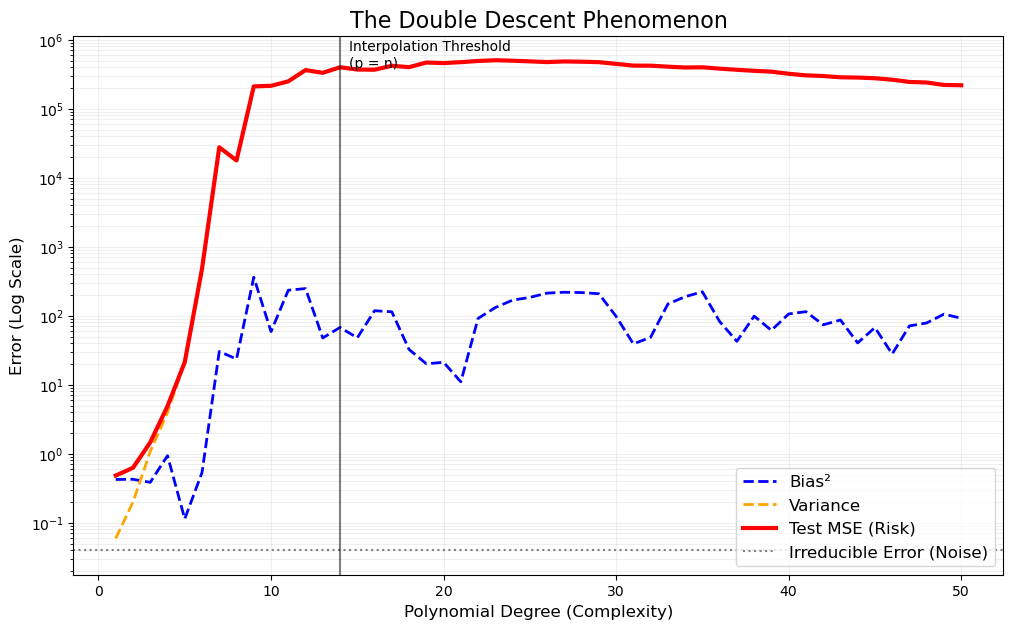

In [4]:
plt.figure(figsize=(12, 7))

# Plot Components
plt.plot(degrees, bias_squared_history, label='Bias²', color='blue', linewidth=2, linestyle='--')
plt.plot(degrees, variance_history, label='Variance', color='orange', linewidth=2, linestyle='--')
plt.plot(degrees, mse_history, label='Test MSE (Risk)', color='red', linewidth=3)

# Add Irreducible Error Line
plt.axhline(y=sigma_noise**2, color='gray', linestyle=':', label='Irreducible Error (Noise)')

# Mark Interpolation Threshold
# Threshold is when number of parameters (d+1) equals number of samples (N)
# d+1 = N => d = N-1
threshold_degree = N_samples - 1
plt.axvline(x=threshold_degree, color='black', linestyle='-', alpha=0.5)
plt.text(threshold_degree + 0.5, max(mse_history)*0.8, 'Interpolation Threshold\n(p = n)', fontsize=10)

# Styling
plt.yscale('log') # Log scale often makes the double descent clearer
plt.xlabel('Polynomial Degree (Complexity)', fontsize=12)
plt.ylabel('Error (Log Scale)', fontsize=12)
plt.title('The Double Descent Phenomenon', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

### Block 5: The Norm of the Parameters (Demystifying the Descent)
**Goal:** Prove *why* the test error drops in the modern regime.

* **Observation:** The norm will spike massively at $p=n$ (fighting to fit noise with limited freedom) and *decrease* as $p$ increases (the "Minimum Norm" effect).
* **Conclusion:** In the over-parameterized regime, the extra dimensions allow the model to fit the training data perfectly while maintaining a *smaller* total vector norm than at the threshold.

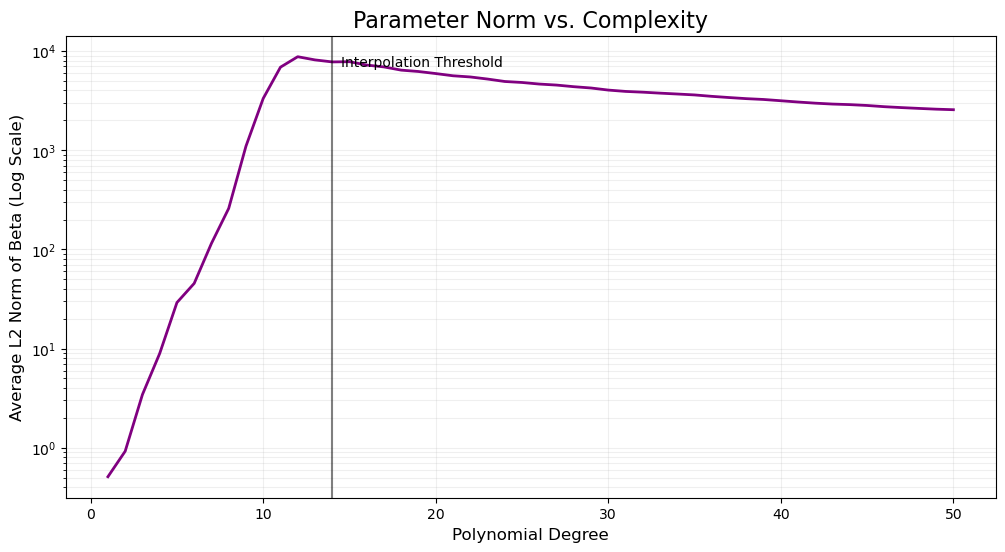

In [5]:
plt.figure(figsize=(12, 6))

plt.plot(degrees, avg_norm_history, color='purple', linewidth=2)

# Mark Threshold
plt.axvline(x=threshold_degree, color='black', linestyle='-', alpha=0.5)
plt.text(threshold_degree + 0.5, max(avg_norm_history)*0.8, 'Interpolation Threshold', fontsize=10)

plt.yscale('log')
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Average L2 Norm of Beta (Log Scale)', fontsize=12)
plt.title('Parameter Norm vs. Complexity', fontsize=16)
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()